# Model Basline
In this notebook we plan to create a continuous-bag-of-words model and feed it into some kind of linear learner.

In [1]:
from pimports import *

## Create CBOW Model

To create this with protein data, we will use sequences of 3 amino acids as a word. These are known as k-mers, and here k=3 as is commonly used in research.

We will then train the model weights with the kmers (words) surrounding a target kmer (word). From these embeddings we will train a linear learner.

In [2]:
# Following https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [3]:
# Load example protein data to make words
prot_df = pd.read_csv("data/acp/train_data.csv")
prot_df

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1
...,...,...
1373,LLKLLKWLLKLLK,0
1374,GFKDWIKGAAKKLIKTVAANIANQ,0
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0
1376,FISAIASFLGKFL,1


In [5]:
# Turn all sequences into kmers (k=3)
from collections import Counter  # Might as well count frequency
kmers = Counter()
for seq in prot_df['sequences'].values:
    for kmer_a, kmer_b, kmer_c in zip(seq, seq[1:], seq[2:]):
        kmer = ''.join([kmer_a, kmer_b, kmer_c])
        kmers[kmer] += 1
list(kmers.items())[:5]

[('RRW', 17), ('RWW', 5), ('WWR', 4), ('WRR', 11), ('RWR', 10)]

In [6]:
word_to_ix = {kmer: i for i, kmer in enumerate(kmers)}
embeds = nn.Embedding(len(word_to_ix), 5)  # x words in vocab, y=5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["RRW"]], dtype=torch.long)
rrw_embed = embeds(lookup_tensor)
print(rrw_embed)

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784]],
       grad_fn=<EmbeddingBackward0>)


In [18]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
vocab = set(kmers)
vocab_size = len(vocab)
kmer_len = 3

data = []

for seq in prot_df['sequences'].values:
    for i in range(0, len(seq) - CONTEXT_SIZE*kmer_len):
        kmer_minus_2 = seq[i:i+kmer_len]
        kmer_minus_1 = seq[i+1:i+kmer_len+1]
        kmer_i = seq[i+2:i+kmer_len+2]
        kmer_plus_1 = seq[i+3:i+kmer_len+3]
        kmer_plus_2 = seq[i+4:i+kmer_len+4]
        data.append(([kmer_minus_2, kmer_minus_1, kmer_plus_1, kmer_plus_2], kmer_i))
data[:5]

[(['RRW', 'RWW', 'WRR', 'RRW'], 'WWR'),
 (['RWW', 'WWR', 'RRW', 'RWR'], 'WRR'),
 (['WWR', 'WRR', 'RWR', 'WRR'], 'RRW'),
 (['WRR', 'RRW', 'WRR', 'RRW'], 'RWR'),
 (['GWK', 'WKS', 'SVF', 'VFR'], 'KSV')]

In [63]:
# Remove duplicates
print(f'Starting with {len(data)} rows')
dupes = {}
for ctx, wrd in data:
    ctx = ','.join(ctx)
    if ctx not in dupes:
        dupes[ctx] = {wrd}
    else:
        dupes[ctx].add(wrd)
duplicates = {ctx for ctx, wrds in dupes.items() if len(wrds) > 1}
print(f'Removing {len(duplicates):,} contexts')

data = [(ctx, word) for ctx, word in data if ','.join(ctx) not in duplicates]
print(f'Now have {len(data)}')

Starting with 24582 rows
Removing 0 contexts
Now have 24582


In [65]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 2**7)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(2**7, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [69]:
model = CBOW(vocab_size, 100)
model

CBOW(
  (embeddings): Embedding(5647, 100)
  (linear1): Linear(in_features=100, out_features=128, bias=True)
  (activation_function1): ReLU()
  (linear2): Linear(in_features=128, out_features=5647, bias=True)
  (activation_function2): LogSoftmax(dim=-1)
)

In [67]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

I played with the optimizer a lot. With a large lr and SGD, I got NaN loss reliably. I decided to avoid this by using Adam optimizer which allows for weight decay, which tries to minimize the weights. I also found that higher learning rate is fine for a baseline model, but not for a very good one, as there will be lots of overfitting.

In [74]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.04, weight_decay=0.001)
num_train = int(0.8*len(data))
num_test = len(data) - num_train
train_data, test_data = torch.utils.data.random_split(data, [num_train, num_test], generator=torch.Generator().manual_seed(42))

#TRAINING
for epoch in range(100):
    print(f'Starting epoch {epoch}')
    total_loss = 0

    for context, target in train_data:
        context_vector = make_context_vector(context, word_to_ix)
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))
    print(total_loss)
    if np.isnan(float(f'{total_loss}')):
        break

    correct_guesses = 0
    for context, target in test_data:
        context_vector = make_context_vector(context, word_to_ix)
        log_probs = model(context_vector)
        guessed = ix_to_word[torch.argmax(log_probs[0]).item()]
        if guessed == target:
            correct_guesses += 1
    print(f'Done with epoch {epoch} and got accuracy {correct_guesses}/{len(test_data)}={100*(correct_guesses / len(test_data)):.5f}%')

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

Starting epoch 0
tensor(11826.0049, grad_fn=<AddBackward0>)
Done with epoch 0 and got accuracy 1616/4917=32.86557%
Starting epoch 1
tensor(17810.7676, grad_fn=<AddBackward0>)
Done with epoch 1 and got accuracy 1387/4917=28.20826%
Starting epoch 2
tensor(6046.8428, grad_fn=<AddBackward0>)
Done with epoch 2 and got accuracy 1642/4917=33.39435%
Starting epoch 3
tensor(5740.8506, grad_fn=<AddBackward0>)
Done with epoch 3 and got accuracy 1673/4917=34.02481%
Starting epoch 4
tensor(5520.6245, grad_fn=<AddBackward0>)
Done with epoch 4 and got accuracy 1681/4917=34.18751%
Starting epoch 5
tensor(4224.8203, grad_fn=<AddBackward0>)
Done with epoch 5 and got accuracy 1727/4917=35.12304%
Starting epoch 6
tensor(2669.7395, grad_fn=<AddBackward0>)
Done with epoch 6 and got accuracy 1787/4917=36.34330%
Starting epoch 7
tensor(1649.0242, grad_fn=<AddBackward0>)
Done with epoch 7 and got accuracy 1824/4917=37.09579%
Starting epoch 8
tensor(1032.1907, grad_fn=<AddBackward0>)
Done with epoch 8 and got a

KeyboardInterrupt: 

In [75]:
# Final loss and accuracy
train_guesses = 0
for context, target in train_data:
    context_vector = make_context_vector(context, word_to_ix)
    log_probs = model(context_vector)
    guessed = ix_to_word[torch.argmax(log_probs[0]).item()]
    if guessed == target:
        train_guesses += 1

correct_guesses = 0
for context, target in test_data:
    context_vector = make_context_vector(context, word_to_ix)
    log_probs = model(context_vector)
    guessed = ix_to_word[torch.argmax(log_probs[0]).item()]
    if guessed == target:
        correct_guesses += 1
print(f'Done with training and got test accuracy {correct_guesses}/{len(test_data)}={100*(correct_guesses / len(test_data)):.5f}% and train accuracy {train_guesses}/{len(train_data)}={100*(train_guesses / len(train_data)):.5f}%')

Done with training and got test accuracy 1880/4917=38.23470% and train accuracy 19647/19665=99.90847%


38% test accuracy and 99% train accuracy :D Smells like overfitting. 

## Linear model for guessing label

In [78]:
def get_embeddings(seq):
    # Convert to kmers and lookup
    kmers = []
    for i in range(0, len(seq) - 2):
        kmer = seq[i:i+3]
        kmers.append(kmer)
    return model.embeddings(torch.tensor([word_to_ix[kmer] for kmer in kmers])).cpu().detach().numpy()

# Test
# get_embeddings('RRWR')

In [79]:
prot_df['embeddings'] = prot_df['sequences'].map(get_embeddings)

prot_df['mean_embeddings'] = prot_df['embeddings'].map(lambda x: x.mean(0))
prot_df['max_embeddings'] = prot_df['embeddings'].map(lambda x: x.max(0))
prot_df['sum_embeddings'] = prot_df['embeddings'].map(lambda x: x.sum(0))

mean_embeddings = pd.DataFrame(prot_df['mean_embeddings'].tolist())
max_embeddings = pd.DataFrame(prot_df['max_embeddings'].tolist())
sum_embeddings = pd.DataFrame(prot_df['sum_embeddings'].tolist())
all_embeddings = mean_embeddings.merge(max_embeddings, left_index=True, right_index=True).merge(sum_embeddings, left_index=True, right_index=True)
all_embeddings

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,90,91,92,93,94,95,96,97,98,99
0,0.444002,0.056918,-0.815464,0.573925,-0.183249,-0.246367,0.569723,0.364270,0.693070,-0.056975,...,7.795949,3.839921,-2.149093,-6.283219,-7.843275,4.828357,3.948138,0.419173,8.552602,-1.960219
1,0.126992,0.049871,0.606737,-0.144443,0.298717,-0.233551,-0.267371,-0.264926,-0.069222,0.448553,...,6.313254,-2.015187,1.417841,9.451605,-5.477207,0.024754,-3.430053,-0.231232,-2.715113,7.010417
2,-0.223886,0.235404,-0.050235,0.462699,0.066580,-0.155796,-0.264497,0.078733,-0.048532,0.270114,...,-5.322323,6.068357,-3.053094,-1.743851,-0.013190,-11.695951,-7.152821,9.071996,0.459658,-0.156087
3,0.556409,-0.207510,0.029089,0.204503,0.083392,0.393404,-0.198617,0.778663,0.161003,-0.387152,...,1.107438,-5.195529,0.497815,0.000678,-1.462043,7.551419,3.362416,5.714870,-0.686924,-8.062219
4,0.145889,0.275106,0.067376,-0.089389,-0.116227,-0.378428,-0.191439,0.203924,-0.131348,0.213792,...,3.427410,4.751172,1.452300,5.397296,-2.089801,-1.887212,3.218089,4.966340,-1.001770,-0.731229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,-0.496204,0.157467,0.307309,0.005698,-0.306633,-0.789912,0.297118,0.385418,-0.273252,0.047054,...,3.260774,10.666686,5.799181,-3.966213,5.669536,-2.449130,3.074576,-2.413268,-4.381186,1.743143
1374,0.009337,-0.427140,0.381318,0.053133,0.120318,0.055844,-0.139122,0.093994,0.039429,0.157610,...,-6.919102,6.566476,-5.235083,-5.783195,-3.001599,-4.548702,-2.995428,-2.787709,-0.486865,1.645817
1375,-0.151590,0.133433,0.162137,0.189756,0.209770,0.046477,-0.192852,-0.224525,-0.338736,0.124081,...,-2.011648,-10.000915,-12.864613,-10.397711,10.204558,-11.258795,8.158518,8.305094,3.359185,-8.301657
1376,0.188698,0.049085,0.467198,-0.159195,0.121160,0.396945,-0.483380,0.266270,0.282483,0.095831,...,-6.366853,2.664019,-1.250323,1.958580,-2.589087,-1.681041,5.271566,0.630387,-3.710766,-3.578943


### RandomForest

/home/jong/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.71      0.72       150
           1       0.67      0.68      0.67       126

    accuracy                           0.70       276
   macro avg       0.70      0.70      0.70       276
weighted avg       0.70      0.70      0.70       276



/home/jong/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


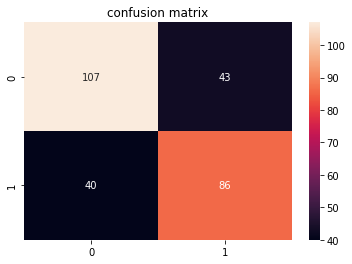

In [81]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=1_000, max_depth=10, random_state=42)

from sklearn.model_selection import train_test_split
X, y = all_embeddings, prot_df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit RandomForestClassifier
rfc.fit(X_train, y_train)
# Predict the test set labels
y_pred = rfc.predict(X_test)

# Analyze results
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('confusion matrix')

print(classification_report(y_test,y_pred))

Around 70% accuracy. That's pretty good for a baseline! Especially with a very overfitting embedding matrix.